In [135]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

In [136]:
from datetime import date, datetime, time, timedelta

In [137]:
import math 
import pandas_datareader as web 
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential  #load_model
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [138]:
main_company = 'BTC-USD'

start = datetime(2010, 1, 1)

df = web.DataReader(main_company, 'yahoo', start)
df['Date']=df.index

df=df.reset_index(drop=True)

In [139]:
df.to_csv("../out/LSTM/hiep_yahoo_in.csv")

In [140]:
df

,High,Low,Open,Close,Volume,Adj Close,Date
0,468.174011,452.421997,465.864014,457.334015,21056800,457.334015,2014-09-17
1,456.859985,413.104004,456.859985,424.440002,34483200,424.440002,2014-09-18
2,427.834991,384.532013,424.102997,394.795990,37919700,394.795990,2014-09-19
3,423.295990,389.882996,394.673004,408.903992,36863600,408.903992,2014-09-20
4,412.425995,393.181000,408.084991,398.821014,26580100,398.821014,2014-09-21
...,...,...,...,...,...,...,...
2839,21783.724609,21016.269531,21496.494141,21027.294922,18027170497,21027.294922,2022-06-26
2840,21478.089844,20620.199219,21028.238281,20735.478516,20965695707,20735.478516,2022-06-27
2841,21164.423828,20228.812500,20731.544922,20280.634766,21381535161,20280.634766,2022-06-28
2842,20364.156250,19937.791016,20281.169922,20104.023438,23552740328,20104.023438,2022-06-29


In [141]:
# get the number of rows and columns in the data set
df.shape

(2844, 7)

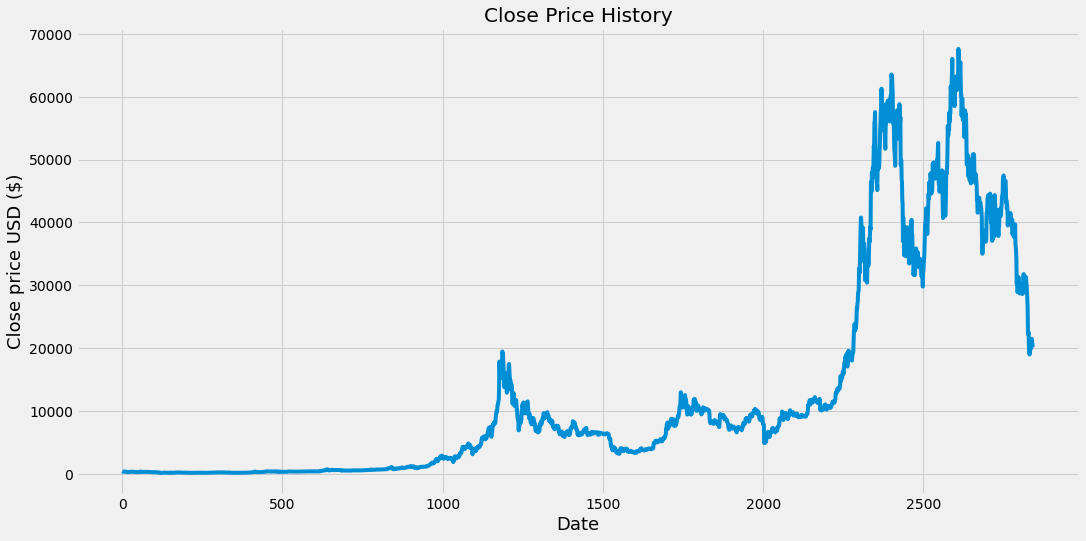

In [142]:
# visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price USD ($)', fontsize=18)
plt.show()

In [143]:
# create a new df with only the "close" column
data = df.filter({'Close'})
# convert the df to a numpy array
dataset = data.values
# get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

2276

In [144]:
# scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data


array([[0.00414359],
       [0.00365546],
       [0.00321557],
       ...,
       [0.29830705],
       [0.29568627],
       [0.29527143]])

In [145]:
## create the training data set
# create the scaled training data set
train_data = scaled_data[0:training_data_len, :]
# split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

print(x_train)
print(y_train)

[array([0.00414359, 0.00365546, 0.00321557, 0.00342492, 0.0032753 ,
       0.00332473, 0.0038239 , 0.00363714, 0.00346454, 0.00335845,
       0.00328567, 0.00295417, 0.00292874, 0.00309905, 0.00304965,
       0.00292288, 0.00269198, 0.00223721, 0.00211322, 0.00225521,
       0.00234585, 0.00259445, 0.0027738 , 0.0027224 , 0.00273334,
       0.00297447, 0.00315054, 0.0033057 , 0.00321523, 0.00303393,
       0.00305177, 0.0031658 , 0.00313766, 0.00303822, 0.00309209,
       0.00304287, 0.00267573, 0.00267466, 0.00251033, 0.00262063,
       0.00259518, 0.00266387, 0.00233701, 0.00248116, 0.00237752,
       0.00219096, 0.00219308, 0.00221774, 0.00226134, 0.00239481,
       0.00254029, 0.00243827, 0.00248387, 0.00274766, 0.00280197,
       0.00281341, 0.00364242, 0.00360048, 0.00326041, 0.00293862]), array([0.00365546, 0.00321557, 0.00342492, 0.0032753 , 0.00332473,
       0.0038239 , 0.00363714, 0.00346454, 0.00335845, 0.00328567,
       0.00295417, 0.00292874, 0.00309905, 0.00304965, 0.00

In [146]:
# convert the x_train and y_train to number arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [147]:
# reshape the data, input [samples, time steps, features] which is require for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2216, 60, 1)

In [148]:
# build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


In [149]:
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [150]:
# train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2216/2216 [==============================] - 34s 15ms/step - loss: 2.0721e-04


In [151]:
## create the testing data set
# create a new array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - 60:, :]
# create the data sets x_test nad y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [152]:
# convert the data to a numpy array
x_test = np.array(x_test)

In [153]:
# reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [154]:
# get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


18/18 [==============================] - 1s 9ms/step


In [155]:
# get the rmse (root mean squared error)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

7473.992010412082

C:\Users\Hiep\AppData\Local\Temp\ipykernel_15740\3363781652.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Prediction'] = predictions


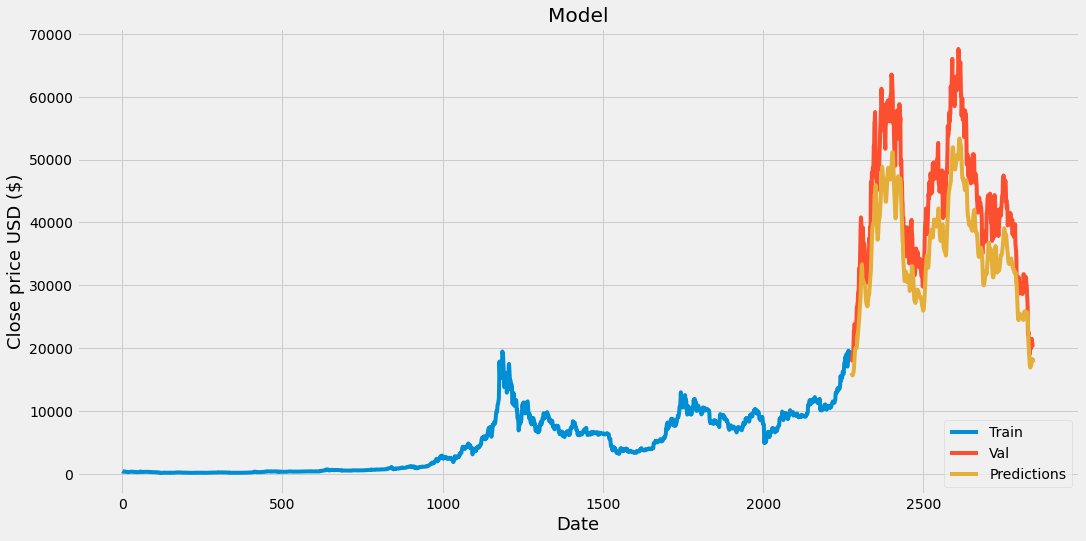

In [156]:
# plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Prediction'] = predictions
# visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Prediction']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [157]:
# show the valid and predicted prices
valid

,Close,Prediction
2276,18264.992188,16105.731445
2277,18058.904297,15916.560547
2278,18803.656250,15720.491211
2279,19142.382812,15705.284180
2280,19246.644531,15836.001953
...,...,...
2839,21027.294922,18149.460938
2840,20735.478516,18283.630859
2841,20280.634766,18254.539062
2842,20104.023438,18063.210938


In [158]:
valid.index = pd.to_datetime(df['Date'].loc[training_data_len:].copy())
valid.to_csv('../out/LSTM/hiep_out.csv')
valid

,Close,Prediction
Date,,
2020-12-10,18264.992188,16105.731445
2020-12-11,18058.904297,15916.560547
2020-12-12,18803.656250,15720.491211
2020-12-13,19142.382812,15705.284180
2020-12-14,19246.644531,15836.001953
...,...,...
2022-06-26,21027.294922,18149.460938
2022-06-27,20735.478516,18283.630859
2022-06-28,20280.634766,18254.539062
